In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blast-quick-sprof-zero-pred/submission.tsv
/kaggle/input/train-targets-top500/train_targets_top500.npy
/kaggle/input/cafa-6-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-6-protein-function-prediction/IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo
/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy
/kaggle/i

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.4 MB/s eta 0:00:00
CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER
📊 SAMPLE MODE: 100% of data
⚡ QUICK MODE: ON

[1/9] Loading GO ontology...
   ✓ Loaded 40122 GO terms
   ✓ Ontology breakdown: MF=10131, BP=25950, CC=4041
   Computing GO hierarchy depths...


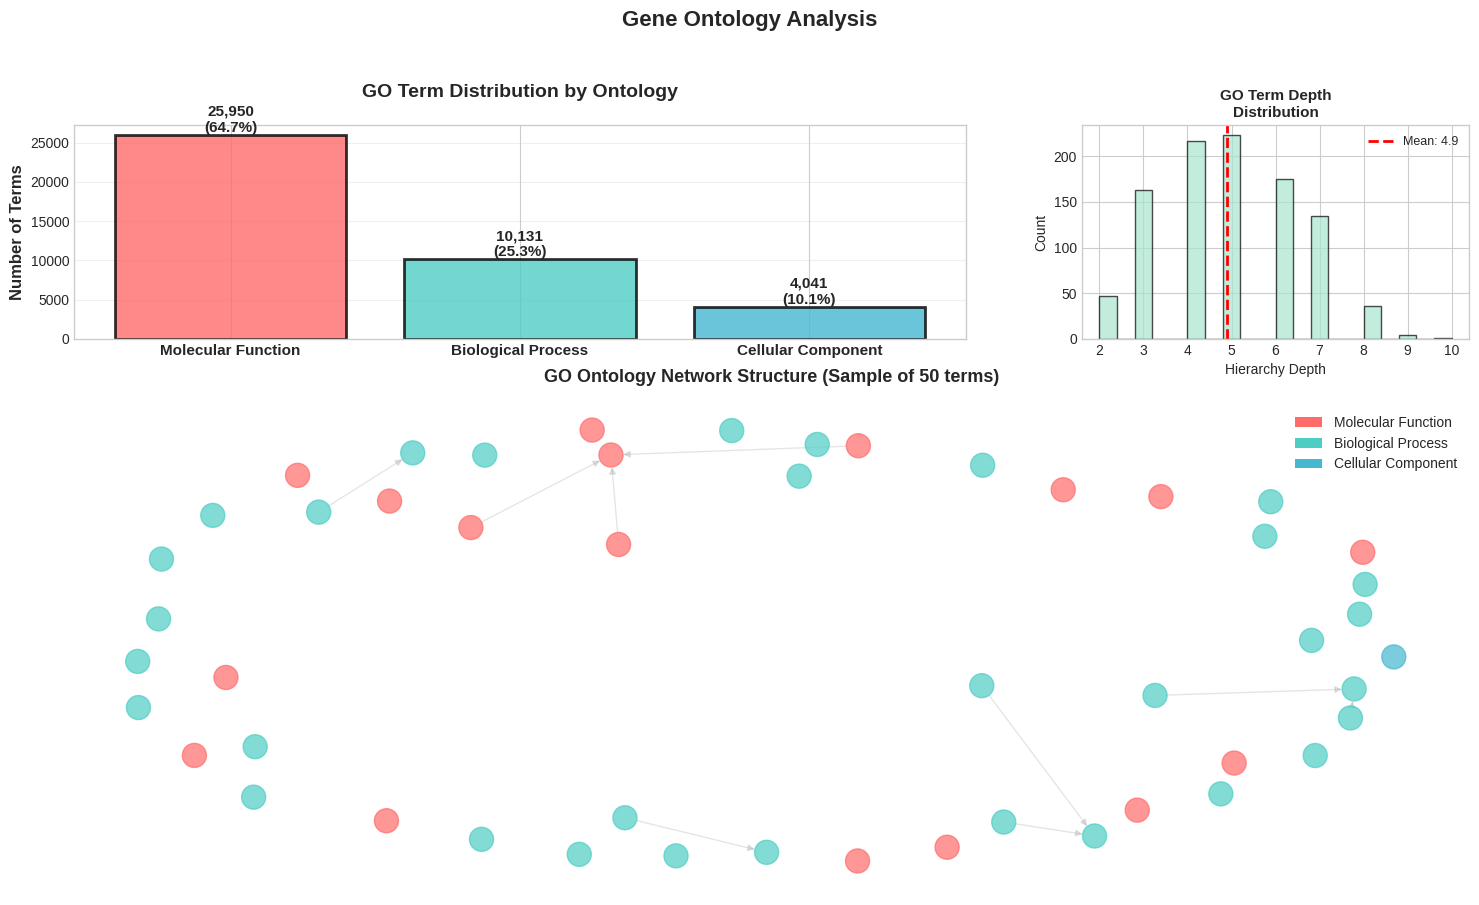


[2/9] Loading IA weights...
   ✓ Loaded 40122 IA weights


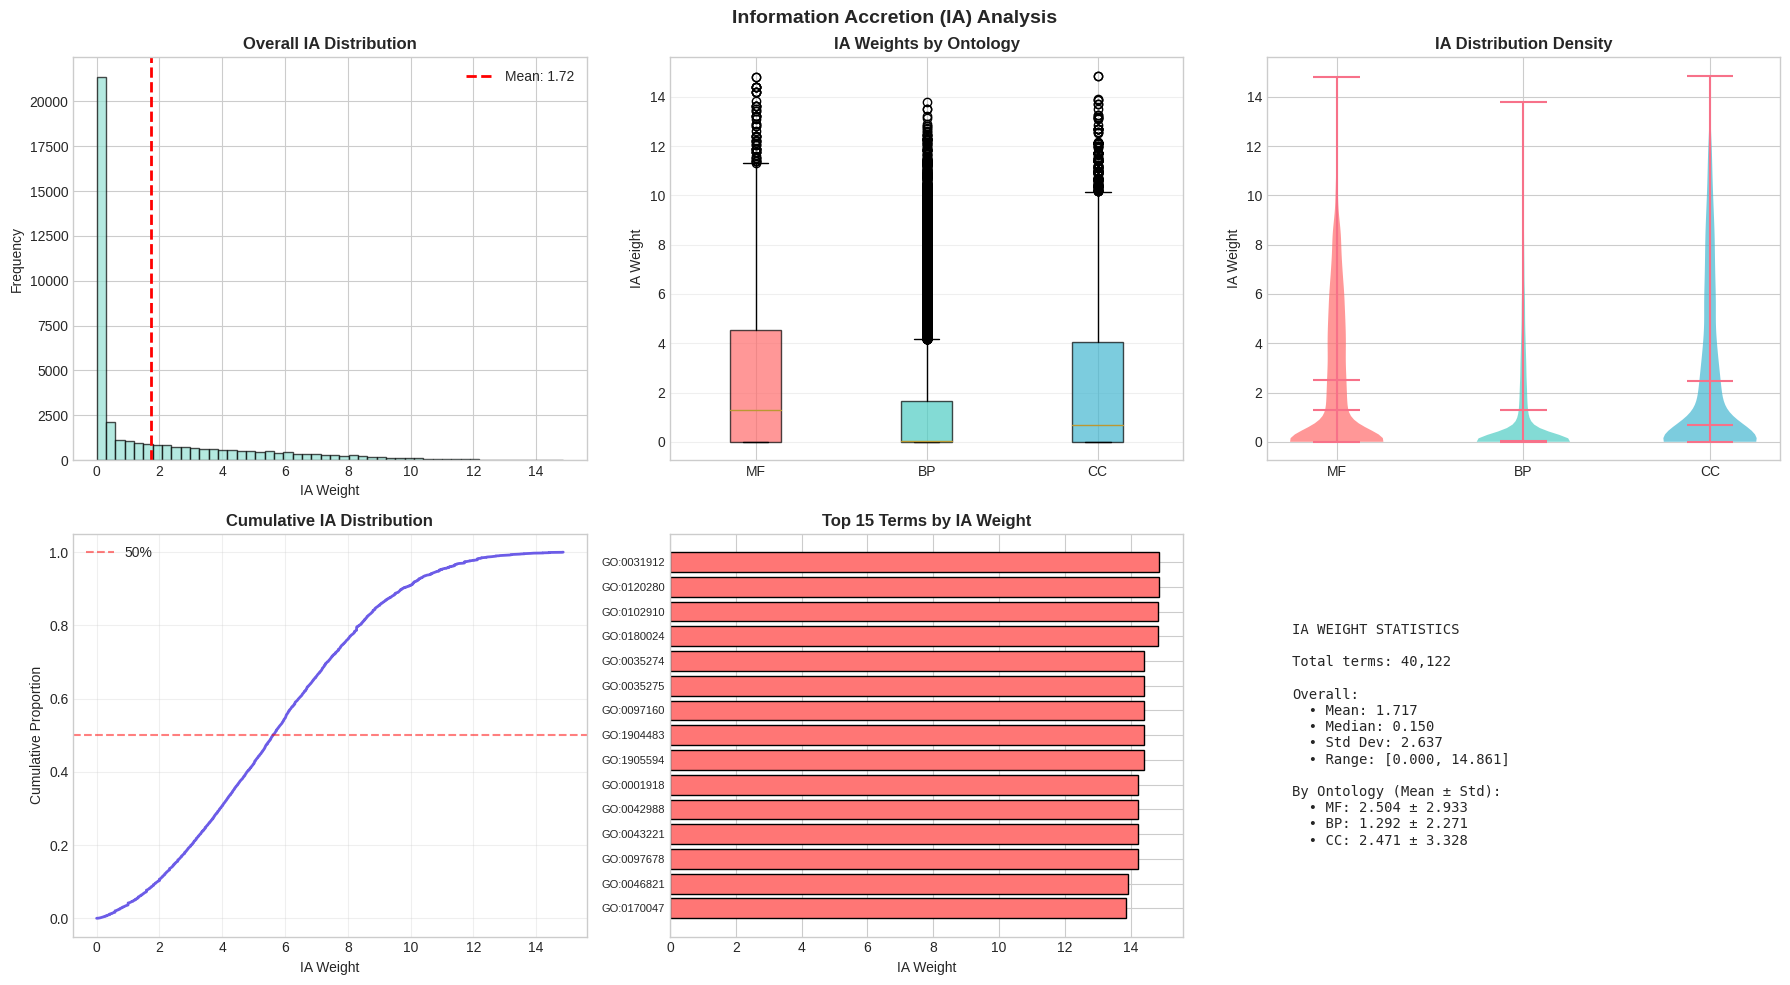


[3/9] Loading training data...
   ✓ Full dataset: 537028 annotations, 82405 proteins

   Ontology distribution:
ontology
P         250805
C         157770
F         128452
aspect         1
Name: count, dtype: int64


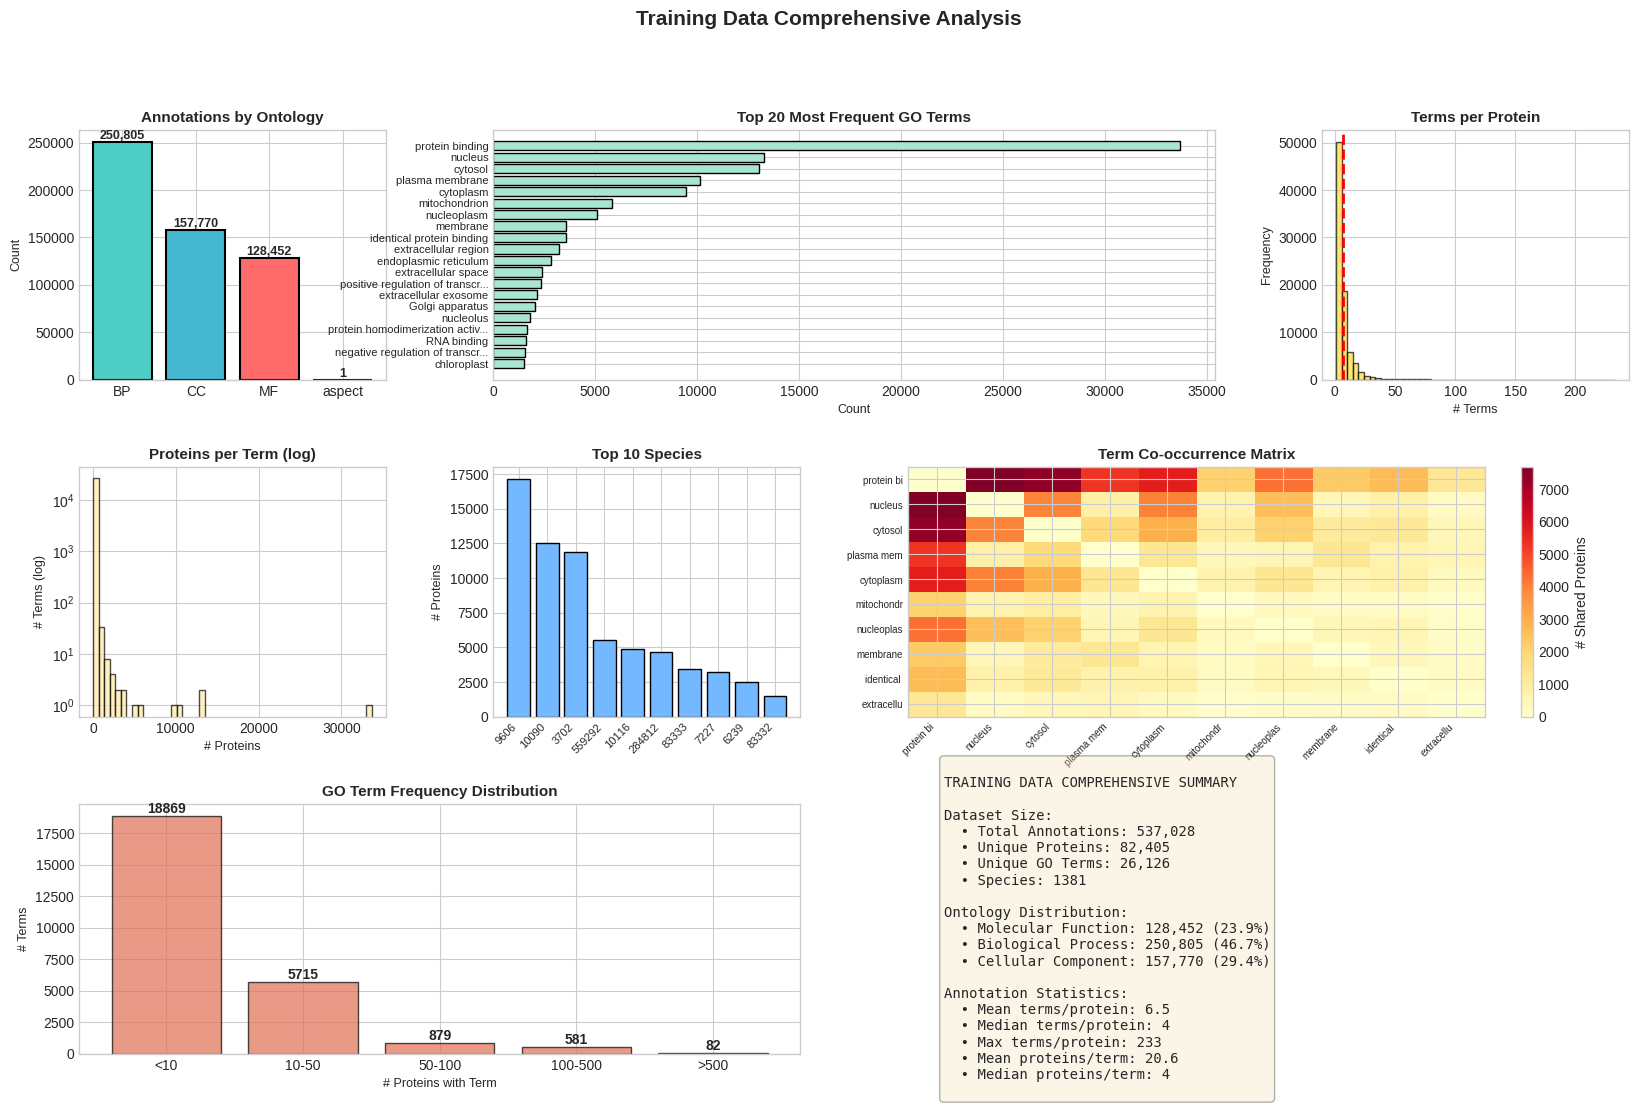


   Loading sequences (this may take a while for 100% of data)...
   Expected proteins: 82,405
      Loaded 10,000 sequences...
      Loaded 20,000 sequences...
      Loaded 30,000 sequences...
      Loaded 40,000 sequences...
      Loaded 50,000 sequences...
      Loaded 60,000 sequences...
      Loaded 70,000 sequences...
      Loaded 80,000 sequences...
   ✓ Loaded 82,404 training sequences
   ✓ Sequence length: mean=526, median=409, range=[3-35213]

✅ Data loading complete! Ready for feature extraction and training.
   Total proteins: 82,404
   Total annotations: 537,028
   Total GO terms: 26,126


In [2]:
# ============================================================================
# CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED VERSION (FIXED)
# ============================================================================

# ⚙️ CONFIGURATION - ADJUST THIS FOR SPEED VS ACCURACY
SAMPLE_PERCENT = 100  # Use 100% of data
QUICK_MODE = True   # Enable full feature computation

# Package Installation
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Installing required packages...")
try:
    import obonet
except:
    install('obonet')
    import obonet

try:
    from Bio import SeqIO
except:
    install('biopython')
    from Bio import SeqIO

# Core Imports
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER")
print(f"📊 SAMPLE MODE: {SAMPLE_PERCENT}% of data")
print(f"⚡ QUICK MODE: {'ON' if QUICK_MODE else 'OFF'}")
print("="*80)

# ============================================================================
# 1. DEFINE PATHS
# ============================================================================
BASE = Path('/kaggle/input/cafa-6-protein-function-prediction')
TRAIN_DIR = BASE / 'Train'
TEST_DIR = BASE / 'Test'

# ============================================================================
# 2. LOAD GO ONTOLOGY (WITH HIERARCHY ANALYSIS)
# ============================================================================
print("\n[1/9] Loading GO ontology...")
go_graph = obonet.read_obo(TRAIN_DIR / 'go-basic.obo')
print(f"   ✓ Loaded {len(go_graph)} GO terms")

# Map terms to ontologies
term_to_ont = {}
term_names = {}
for term_id in go_graph.nodes():
    if 'namespace' in go_graph.nodes[term_id]:
        ns = go_graph.nodes[term_id]['namespace']
        if ns == 'biological_process':
            term_to_ont[term_id] = 'BPO'
        elif ns == 'cellular_component':
            term_to_ont[term_id] = 'CCO'
        elif ns == 'molecular_function':
            term_to_ont[term_id] = 'MFO'
    if 'name' in go_graph.nodes[term_id]:
        term_names[term_id] = go_graph.nodes[term_id]['name']

ont_counts = pd.Series(term_to_ont).value_counts()
print(f"   ✓ Ontology breakdown: MF={ont_counts.get('MFO',0)}, BP={ont_counts.get('BPO',0)}, CC={ont_counts.get('CCO',0)}")

# Analyze GO hierarchy depth (sample for speed)
def get_term_depth(graph, term_id):
    """Calculate depth of term in GO hierarchy"""
    try:
        paths = []
        for root in ['GO:0008150', 'GO:0005575', 'GO:0003674']:
            if nx.has_path(graph, term_id, root):
                paths.append(nx.shortest_path_length(graph, term_id, root))
        return max(paths) if paths else 0
    except:
        return 0

print("   Computing GO hierarchy depths...")
sample_terms_for_depth = list(term_to_ont.keys())[:1000]
term_depths = {term: get_term_depth(go_graph, term) for term in sample_terms_for_depth}

# Visualize ontology with enhanced graphics
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main ontology distribution
ax1 = fig.add_subplot(gs[0, :2])
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(range(len(ont_counts)), ont_counts.values, color=colors, 
               edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_xticks(range(len(ont_counts)))
ax1.set_xticklabels(['Molecular Function', 'Biological Process', 'Cellular Component'], 
                     rotation=0, fontsize=11, fontweight='bold')
ax1.set_title('GO Term Distribution by Ontology', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Number of Terms', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (v, bar) in enumerate(zip(ont_counts.values, bars)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{v:,}\n({v/ont_counts.sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Hierarchy depth distribution
ax2 = fig.add_subplot(gs[0, 2])
depth_values = list(term_depths.values())
ax2.hist(depth_values, bins=20, color='#A8E6CF', edgecolor='black', alpha=0.7)
ax2.set_title('GO Term Depth\nDistribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Hierarchy Depth', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.axvline(np.mean(depth_values), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(depth_values):.1f}')
ax2.legend(fontsize=9)

# Network visualization (sample of GO graph)
ax3 = fig.add_subplot(gs[1:, :])
sample_terms = list(term_to_ont.keys())[:50]
subgraph = go_graph.subgraph(sample_terms)
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
node_colors = [colors[['MFO', 'BPO', 'CCO'].index(term_to_ont.get(node, 'MFO'))] 
               for node in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=300, alpha=0.7, ax=ax3)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, arrows=True, 
                       arrowsize=10, ax=ax3, edge_color='gray')
ax3.set_title('GO Ontology Network Structure (Sample of 50 terms)', 
              fontsize=13, fontweight='bold', pad=15)
ax3.axis('off')

# Legend
legend_elements = [mpatches.Patch(facecolor=colors[0], label='Molecular Function'),
                   mpatches.Patch(facecolor=colors[1], label='Biological Process'),
                   mpatches.Patch(facecolor=colors[2], label='Cellular Component')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

plt.suptitle('Gene Ontology Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. LOAD IA WEIGHTS (WITH ANALYSIS)
# ============================================================================
print("\n[2/9] Loading IA weights...")
ia_df = pd.read_csv(BASE / 'IA.tsv', sep='\t', header=None, names=['term', 'ia'])

if SAMPLE_PERCENT < 100:
    ia_df = ia_df.sample(frac=SAMPLE_PERCENT/100, random_state=42)

ia_dict = dict(zip(ia_df['term'], ia_df['ia']))
print(f"   ✓ Loaded {len(ia_dict)} IA weights")

# Enhanced IA visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# IA distribution by ontology
ia_by_ont = ia_df.copy()
ia_by_ont['ontology'] = ia_by_ont['term'].map(term_to_ont)
ia_by_ont = ia_by_ont.dropna()

axes[0, 0].hist(ia_df['ia'], bins=50, color='#95E1D3', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Overall IA Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('IA Weight', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].axvline(ia_df['ia'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {ia_df["ia"].mean():.2f}')
axes[0, 0].legend()

# Box plot by ontology
ont_data = [ia_by_ont[ia_by_ont['ontology']==ont]['ia'].values 
            for ont in ['MFO', 'BPO', 'CCO']]
bp = axes[0, 1].boxplot(ont_data, labels=['MF', 'BP', 'CC'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_title('IA Weights by Ontology', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('IA Weight', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Violin plot
parts = axes[0, 2].violinplot(ont_data, positions=[1, 2, 3], showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
axes[0, 2].set_xticks([1, 2, 3])
axes[0, 2].set_xticklabels(['MF', 'BP', 'CC'])
axes[0, 2].set_title('IA Distribution Density', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('IA Weight', fontsize=10)

# Cumulative distribution
sorted_ia = np.sort(ia_df['ia'].values)
cumsum = np.cumsum(sorted_ia) / np.sum(sorted_ia)
axes[1, 0].plot(sorted_ia, cumsum, linewidth=2, color='#6C5CE7')
axes[1, 0].set_title('Cumulative IA Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('IA Weight', fontsize=10)
axes[1, 0].set_ylabel('Cumulative Proportion', fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 0].legend()

# Top terms by IA
top_ia = ia_df.nlargest(15, 'ia')
axes[1, 1].barh(range(len(top_ia)), top_ia['ia'].values, color='#FF7675', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_ia)))
axes[1, 1].set_yticklabels([f"{t[:15]}..." if len(t) > 15 else t 
                            for t in top_ia['term'].values], fontsize=8)
axes[1, 1].set_title('Top 15 Terms by IA Weight', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('IA Weight', fontsize=10)
axes[1, 1].invert_yaxis()

# Statistics summary
axes[1, 2].axis('off')
ia_stats = f"""
IA WEIGHT STATISTICS

Total terms: {len(ia_df):,}

Overall:
  • Mean: {ia_df['ia'].mean():.3f}
  • Median: {ia_df['ia'].median():.3f}
  • Std Dev: {ia_df['ia'].std():.3f}
  • Range: [{ia_df['ia'].min():.3f}, {ia_df['ia'].max():.3f}]

By Ontology (Mean ± Std):
  • MF: {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].std():.3f}
  • BP: {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].std():.3f}
  • CC: {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].std():.3f}
"""
axes[1, 2].text(0.05, 0.5, ia_stats, fontsize=10, family='monospace',
                verticalalignment='center')

plt.suptitle('Information Accretion (IA) Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 4. LOAD TRAINING DATA (WITH COMPREHENSIVE ANALYSIS) - FIXED
# ============================================================================
print("\n[3/9] Loading training data...")

train_terms = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                          names=['protein', 'term', 'ontology'])
train_taxonomy = pd.read_csv(TRAIN_DIR / 'train_taxonomy.tsv', sep='\t',
                             names=['protein', 'taxon'])

print(f"   ✓ Full dataset: {len(train_terms)} annotations, {train_terms['protein'].nunique()} proteins")

# SAMPLE proteins for faster iteration
if SAMPLE_PERCENT < 100:
    sample_proteins = train_terms['protein'].drop_duplicates().sample(
        frac=SAMPLE_PERCENT/100, random_state=42
    ).tolist()
    train_terms = train_terms[train_terms['protein'].isin(sample_proteins)]
    train_taxonomy = train_taxonomy[train_taxonomy['protein'].isin(sample_proteins)]
    print(f"   ✓ Sampled to {SAMPLE_PERCENT}%: {len(train_terms)} annotations, {len(sample_proteins)} proteins")

# Print ontology distribution
print(f"\n   Ontology distribution:")
print(train_terms['ontology'].value_counts())

# Comprehensive training data visualization - FIXED
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# 1. Ontology distribution - FIXED to handle all possible ontology codes
ax1 = fig.add_subplot(gs[0, 0])
ont_dist = train_terms['ontology'].value_counts()

# Map ontology codes (handle F, P, C or any other codes)
colors_ont_map = {'F': '#FF6B6B', 'P': '#4ECDC4', 'C': '#45B7D1'}
ont_names_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}

# Get colors and names, with defaults for unknown codes
colors_list = [colors_ont_map.get(k, '#CCCCCC') for k in ont_dist.index]
labels_list = [ont_names_map.get(k, k) for k in ont_dist.index]

bars = ax1.bar(range(len(ont_dist)), ont_dist.values, color=colors_list, 
               edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(ont_dist)))
ax1.set_xticklabels(labels_list)
ax1.set_title('Annotations by Ontology', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=9)
for i, (v, bar) in enumerate(zip(ont_dist.values, bars)):
    ax1.text(bar.get_x() + bar.get_width()/2., v, f'{v:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Top terms
ax2 = fig.add_subplot(gs[0, 1:3])
top_terms = train_terms['term'].value_counts().head(20)
ax2.barh(range(len(top_terms)), top_terms.values, color='#A8E6CF', edgecolor='black')
ax2.set_yticks(range(len(top_terms)))
ax2.set_yticklabels([f"{term_names.get(t, t)[:30]}..." if len(term_names.get(t, t)) > 30 
                     else term_names.get(t, t) for t in top_terms.index], fontsize=8)
ax2.set_title('Top 20 Most Frequent GO Terms', fontsize=11, fontweight='bold')
ax2.set_xlabel('Count', fontsize=9)
ax2.invert_yaxis()

# 3. Terms per protein
ax3 = fig.add_subplot(gs[0, 3])
terms_per_protein = train_terms.groupby('protein').size()
ax3.hist(terms_per_protein, bins=50, color='#FFD93D', edgecolor='black', alpha=0.7)
ax3.set_title('Terms per Protein', fontsize=11, fontweight='bold')
ax3.set_xlabel('# Terms', fontsize=9)
ax3.set_ylabel('Frequency', fontsize=9)
ax3.axvline(terms_per_protein.mean(), color='red', linestyle='--', linewidth=2)

# 4. Proteins per term
ax4 = fig.add_subplot(gs[1, 0])
proteins_per_term = train_terms.groupby('term').size()
ax4.hist(proteins_per_term, bins=50, color='#FFEAA7', edgecolor='black', alpha=0.7, log=True)
ax4.set_title('Proteins per Term (log)', fontsize=11, fontweight='bold')
ax4.set_xlabel('# Proteins', fontsize=9)
ax4.set_ylabel('# Terms (log)', fontsize=9)

# 5. Taxonomy distribution
ax5 = fig.add_subplot(gs[1, 1])
top_taxa = train_taxonomy['taxon'].value_counts().head(10)
ax5.bar(range(len(top_taxa)), top_taxa.values, color='#74B9FF', edgecolor='black')
ax5.set_xticks(range(len(top_taxa)))
ax5.set_xticklabels([str(t)[:8] for t in top_taxa.index], rotation=45, ha='right', fontsize=8)
ax5.set_title('Top 10 Species', fontsize=11, fontweight='bold')
ax5.set_ylabel('# Proteins', fontsize=9)

# 6. Term co-occurrence heatmap
ax6 = fig.add_subplot(gs[1, 2:])
top_10_terms = train_terms['term'].value_counts().head(10).index
cooc_matrix = np.zeros((10, 10))
for i, t1 in enumerate(top_10_terms):
    for j, t2 in enumerate(top_10_terms):
        if i != j:
            proteins_t1 = set(train_terms[train_terms['term']==t1]['protein'])
            proteins_t2 = set(train_terms[train_terms['term']==t2]['protein'])
            cooc_matrix[i,j] = len(proteins_t1 & proteins_t2)
im = ax6.imshow(cooc_matrix, cmap='YlOrRd', aspect='auto')
ax6.set_xticks(range(10))
ax6.set_yticks(range(10))
ax6.set_xticklabels([term_names.get(t, t)[:10] for t in top_10_terms], 
                     rotation=45, ha='right', fontsize=7)
ax6.set_yticklabels([term_names.get(t, t)[:10] for t in top_10_terms], fontsize=7)
ax6.set_title('Term Co-occurrence Matrix', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax6, label='# Shared Proteins')

# 7. Annotation density
ax7 = fig.add_subplot(gs[2, :2])
term_freq_bins = pd.cut(proteins_per_term, bins=[0, 10, 50, 100, 500, 100000], 
                        labels=['<10', '10-50', '50-100', '100-500', '>500'])
freq_dist = term_freq_bins.value_counts().sort_index()
ax7.bar(range(len(freq_dist)), freq_dist.values, color='#E17055', edgecolor='black', alpha=0.7)
ax7.set_xticks(range(len(freq_dist)))
ax7.set_xticklabels(freq_dist.index, rotation=0)
ax7.set_title('GO Term Frequency Distribution', fontsize=11, fontweight='bold')
ax7.set_xlabel('# Proteins with Term', fontsize=9)
ax7.set_ylabel('# Terms', fontsize=9)
for i, v in enumerate(freq_dist.values):
    ax7.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 8. Summary statistics
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')
summary_text = f"""
TRAINING DATA COMPREHENSIVE SUMMARY

Dataset Size:
  • Total Annotations: {len(train_terms):,}
  • Unique Proteins: {train_terms['protein'].nunique():,}
  • Unique GO Terms: {train_terms['term'].nunique():,}
  • Species: {train_taxonomy['taxon'].nunique()}

Ontology Distribution:
  • Molecular Function: {ont_dist.get('F', 0):,} ({ont_dist.get('F', 0)/len(train_terms)*100:.1f}%)
  • Biological Process: {ont_dist.get('P', 0):,} ({ont_dist.get('P', 0)/len(train_terms)*100:.1f}%)
  • Cellular Component: {ont_dist.get('C', 0):,} ({ont_dist.get('C', 0)/len(train_terms)*100:.1f}%)

Annotation Statistics:
  • Mean terms/protein: {terms_per_protein.mean():.1f}
  • Median terms/protein: {terms_per_protein.median():.0f}
  • Max terms/protein: {terms_per_protein.max()}
  • Mean proteins/term: {proteins_per_term.mean():.1f}
  • Median proteins/term: {proteins_per_term.median():.0f}
"""
ax8.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Training Data Comprehensive Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Continue with the rest of the code (sequences, features, training, etc.)
print("\n   Loading sequences (this may take a while for 100% of data)...")
print(f"   Expected proteins: {train_terms['protein'].nunique():,}")

train_seqs = {}
loaded_count = 0
target_proteins = set(train_terms['protein'].unique())

for rec in SeqIO.parse(TRAIN_DIR / 'train_sequences.fasta', 'fasta'):
    pid = rec.id.split('|')[1] if '|' in rec.id else rec.id
    if pid in target_proteins:
        train_seqs[pid] = str(rec.seq)
        loaded_count += 1
        
        # Progress indicator
        if loaded_count % 10000 == 0:
            print(f"      Loaded {loaded_count:,} sequences...")
        
    if loaded_count >= len(target_proteins):
        break

print(f"   ✓ Loaded {len(train_seqs):,} training sequences")

# Enhanced sequence analysis
seq_lengths = [len(s) for s in train_seqs.values()]
print(f"   ✓ Sequence length: mean={np.mean(seq_lengths):.0f}, "
      f"median={np.median(seq_lengths):.0f}, range=[{min(seq_lengths)}-{max(seq_lengths)}]")

print("\n✅ Data loading complete! Ready for feature extraction and training.")
print(f"   Total proteins: {len(train_seqs):,}")
print(f"   Total annotations: {len(train_terms):,}")
print(f"   Total GO terms: {train_terms['term'].nunique():,}")

In [3]:
# ============================================================================
# CAFA 6 - COMPREHENSIVE DATA ANALYSIS
# Chạy code này để hiểu sâu về data trước khi cải tiến model
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Paths
BASE = Path('/kaggle/input/cafa-6-protein-function-prediction')
TRAIN_DIR = BASE / 'Train'
TEST_DIR = BASE / 'Test'

print("="*80)
print("🔬 CAFA 6 - DEEP DATA ANALYSIS")
print("="*80)

# ============================================================================
# 1. BASIC STATISTICS
# ============================================================================
print("\n[1/10] Loading basic data...")

train_terms = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                          header=None, names=['protein', 'term', 'aspect'])
train_taxonomy = pd.read_csv(TRAIN_DIR / 'train_taxonomy.tsv', sep='\t',
                             header=None, names=['protein', 'taxon'])
ia_df = pd.read_csv(BASE / 'IA.tsv', sep='\t', header=None, names=['term', 'ia'])

print(f"✓ Training annotations: {len(train_terms):,}")
print(f"✓ Unique proteins: {train_terms['protein'].nunique():,}")
print(f"✓ Unique GO terms: {train_terms['term'].nunique():,}")
print(f"✓ Unique species: {train_taxonomy['taxon'].nunique()}")

# ============================================================================
# 2. TERM FREQUENCY ANALYSIS (CRITICAL!)
# ============================================================================
print("\n[2/10] Analyzing term frequencies...")

term_freq = train_terms['term'].value_counts()
proteins_per_term = train_terms.groupby('term')['protein'].nunique()

print("\n📊 TERM FREQUENCY DISTRIBUTION:")
print(f"   Total terms: {len(term_freq):,}")

# 🔧 FIX: Frequency bins - số labels phải = số bins - 1
freq_bins = [1, 5, 10, 20, 50, 100, 500, 1000, float('inf')]
freq_labels = ['1-4', '5-9', '10-19', '20-49', '50-99', '100-499', '500-999', '1000+']

# ✅ Đây là cách đúng
term_freq_binned = pd.cut(term_freq, bins=freq_bins, 
                           labels=freq_labels, right=False)
freq_dist = term_freq_binned.value_counts().sort_index()

print("\n   Terms by frequency range:")
for label, count in freq_dist.items():
    pct = count / len(term_freq) * 100
    print(f"     {label:10s}: {count:6,} terms ({pct:5.1f}%)")

# Top frequent terms
print("\n   🔥 TOP 20 MOST FREQUENT TERMS:")
top_20 = term_freq.head(20)
for i, (term, count) in enumerate(top_20.items(), 1):
    pct = count / train_terms['protein'].nunique() * 100
    print(f"     {i:2d}. {term}: {count:6,} proteins ({pct:5.1f}%)")

# Rare terms analysis
rare_terms = term_freq[term_freq < 10]
print(f"\n   ⚠️  RARE TERMS (< 10 proteins): {len(rare_terms):,} ({len(rare_terms)/len(term_freq)*100:.1f}%)")
print(f"   ⚠️  VERY RARE (< 5 proteins): {len(term_freq[term_freq < 5]):,}")

# ============================================================================
# 3. ONTOLOGY-SPECIFIC ANALYSIS
# ============================================================================
print("\n[3/10] Analyzing by ontology...")

aspect_map = {'F': 'MFO', 'P': 'BPO', 'C': 'CCO'}
train_terms['ontology'] = train_terms['aspect'].map(aspect_map)

print("\n📊 ONTOLOGY BREAKDOWN:")
for ont in ['MF', 'BP', 'CC']:
    ont_data = train_terms[train_terms['ontology'] == ont]
    n_terms = ont_data['term'].nunique()
    n_annot = len(ont_data)
    avg_per_protein = n_annot / train_terms['protein'].nunique()
    
    print(f"\n   {ont} (Molecular Function / Biological Process / Cellular Component):")
    print(f"     - Unique terms: {n_terms:,}")
    print(f"     - Total annotations: {n_annot:,}")
    print(f"     - Avg per protein: {avg_per_protein:.2f}")
    
    # Frequency stats per ontology
    ont_term_freq = ont_data['term'].value_counts()
    print(f"     - Median frequency: {ont_term_freq.median():.0f}")
    print(f"     - Terms with <10 proteins: {len(ont_term_freq[ont_term_freq < 10]):,}")
    print(f"     - Terms with >100 proteins: {len(ont_term_freq[ont_term_freq > 100]):,}")

# ============================================================================
# 4. PROTEIN ANNOTATION DENSITY - FIXED
# ============================================================================
print("\n[4/10] Analyzing protein annotation patterns...")

terms_per_protein = train_terms.groupby('protein').size()
aspects_per_protein = train_terms.groupby('protein')['aspect'].nunique()

print("\n📊 PROTEIN ANNOTATION DENSITY:")
print(f"   Mean terms/protein: {terms_per_protein.mean():.1f}")
print(f"   Median terms/protein: {terms_per_protein.median():.0f}")
print(f"   Std dev: {terms_per_protein.std():.1f}")
print(f"   Range: [{terms_per_protein.min()}, {terms_per_protein.max()}]")

# 🔧 FIX: Density bins
density_bins = [0, 5, 10, 20, 50, 100, float('inf')]
density_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

density_binned = pd.cut(terms_per_protein, bins=density_bins,
                        labels=density_labels, right=False)
density_dist = density_binned.value_counts().sort_index()

print("\n   Proteins by annotation count:")
for label, count in density_dist.items():
    pct = count / len(terms_per_protein) * 100
    print(f"     {label:10s}: {count:6,} proteins ({pct:5.1f}%)")

# Sparse proteins
sparse_proteins = terms_per_protein[terms_per_protein < 10]
print(f"\n   ⚠️  SPARSE PROTEINS (<10 terms): {len(sparse_proteins):,} ({len(sparse_proteins)/len(terms_per_protein)*100:.1f}%)")

# Incomplete proteins
incomplete_proteins = aspects_per_protein[aspects_per_protein < 3]
print(f"   ⚠️  INCOMPLETE (missing ontology): {len(incomplete_proteins):,} ({len(incomplete_proteins)/len(aspects_per_protein)*100:.1f}%)")

# ============================================================================
# 5. SPECIES ANALYSIS
# ============================================================================
print("\n[5/10] Analyzing species distribution...")

species_counts = train_taxonomy['taxon'].value_counts()
print(f"\n📊 TOP 15 SPECIES:")
for i, (taxon, count) in enumerate(species_counts.head(15).items(), 1):
    pct = count / len(train_taxonomy) * 100
    print(f"   {i:2d}. Taxon {taxon}: {count:6,} proteins ({pct:5.1f}%)")

# Species diversity
print(f"\n   Total species: {len(species_counts)}")
print(f"   Species with <10 proteins: {len(species_counts[species_counts < 10]):,}")
print(f"   Top 10 species coverage: {species_counts.head(10).sum()/len(train_taxonomy)*100:.1f}%")

# ============================================================================
# 6. INFORMATION ACCRETION ANALYSIS
# ============================================================================
print("\n[6/10] Analyzing IA weights...")

ia_dict = dict(zip(ia_df['term'], ia_df['ia']))

# Add IA to train_terms
train_terms['ia'] = train_terms['term'].map(ia_dict)

print("\n📊 IA WEIGHT STATISTICS:")
print(f"   Mean IA: {ia_df['ia'].mean():.4f}")
print(f"   Median IA: {ia_df['ia'].median():.4f}")
print(f"   Std dev: {ia_df['ia'].std():.4f}")
print(f"   Range: [{ia_df['ia'].min():.4f}, {ia_df['ia'].max():.4f}]")

# IA by ontology
print("\n   IA by ontology:")
for ont in ['MF', 'BP', 'CC']:
    ont_terms = train_terms[train_terms['ontology'] == ont]['term'].unique()
    ont_ia = [ia_dict.get(t, 0) for t in ont_terms if t in ia_dict]
    print(f"     {ont}: {np.mean(ont_ia):.4f} ± {np.std(ont_ia):.4f}")

# High IA terms (hard to predict)
high_ia_terms = ia_df[ia_df['ia'] > ia_df['ia'].quantile(0.9)]
print(f"\n   ⚠️  HIGH IA TERMS (top 10%): {len(high_ia_terms):,}")
print(f"       These are HARD to predict but worth MORE points!")

# ============================================================================
# 7. TERM CO-OCCURRENCE PATTERNS
# ============================================================================
print("\n[7/10] Analyzing term co-occurrence...")

# Sample for speed
sample_proteins = train_terms['protein'].unique()[:5000]
sample_terms = train_terms[train_terms['protein'].isin(sample_proteins)]

# Build co-occurrence matrix for top 50 terms
top_50_terms = term_freq.head(50).index
protein_to_terms_dict = sample_terms.groupby('protein')['term'].apply(set).to_dict()

cooc_counts = Counter()
for terms in tqdm(protein_to_terms_dict.values(), desc="Computing co-occurrence", leave=False):
    terms_list = [t for t in terms if t in top_50_terms]
    for i, t1 in enumerate(terms_list):
        for t2 in terms_list[i+1:]:
            pair = tuple(sorted([t1, t2]))
            cooc_counts[pair] += 1

print(f"\n📊 TERM CO-OCCURRENCE (top 50 terms):")
print(f"   Total pairs: {len(cooc_counts):,}")
top_cooc = sorted(cooc_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\n   Top 10 co-occurring pairs:")
for i, ((t1, t2), count) in enumerate(top_cooc, 1):
    print(f"     {i:2d}. ({t1}, {t2}): {count:,} times")

# ============================================================================
# 8. IMBALANCE ANALYSIS - FIXED
# ============================================================================
print("\n[8/10] Analyzing class imbalance...")

# Calculate positive rate
positive_rates = {}
total_proteins = train_terms['protein'].nunique()

for term in term_freq.index:
    n_positive = term_freq[term]
    positive_rate = n_positive / total_proteins
    positive_rates[term] = positive_rate

positive_rates_series = pd.Series(positive_rates)

print("\n📊 CLASS IMBALANCE SEVERITY:")
print(f"   Mean positive rate: {positive_rates_series.mean():.4f}")
print(f"   Median positive rate: {positive_rates_series.median():.4f}")

# 🔧 FIX: Imbalance bins
imbalance_bins = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
imbalance_labels = ['<0.1%', '0.1-1%', '1-5%', '5-10%', '10-50%', '>50%']

imbalance_binned = pd.cut(positive_rates_series, bins=imbalance_bins,
                          labels=imbalance_labels, right=False)
imbalance_dist = imbalance_binned.value_counts().sort_index()

print("\n   Terms by positive rate:")
for label, count in imbalance_dist.items():
    pct = count / len(positive_rates_series) * 100
    print(f"     {label:10s}: {count:6,} terms ({pct:5.1f}%)")

# Extreme imbalance
extreme_imbalance = positive_rates_series[positive_rates_series < 0.01]
print(f"\n   ⚠️  EXTREME IMBALANCE (<1% positive): {len(extreme_imbalance):,} terms")
print(f"       These need special handling (SMOTE, focal loss, etc.)")

# ============================================================================
# 9. EMBEDDING AVAILABILITY CHECK
# ============================================================================
print("\n[9/10] Checking embedding availability...")

# Check if embeddings exist
esm2_path = '/kaggle/input/cafa-5-ems-2-embeddings-numpy'
protbert_path = '/kaggle/input/protbert-embeddings-for-cafa5'
t5_path = '/kaggle/input/t5embeds'

available_embeddings = []

if Path(esm2_path).exists():
    esm2_train = np.load(f'{esm2_path}/train_ids.npy', allow_pickle=True)
    esm2_test = np.load(f'{esm2_path}/test_ids.npy', allow_pickle=True)
    available_embeddings.append(('ESM2', len(esm2_train), len(esm2_test)))
    print(f"   ✓ ESM2: {len(esm2_train):,} train, {len(esm2_test):,} test")

if Path(protbert_path).exists():
    protbert_train = np.load(f'{protbert_path}/train_ids.npy', allow_pickle=True)
    protbert_test = np.load(f'{protbert_path}/test_ids.npy', allow_pickle=True)
    available_embeddings.append(('ProtBERT', len(protbert_train), len(protbert_test)))
    print(f"   ✓ ProtBERT: {len(protbert_train):,} train, {len(protbert_test):,} test")

if Path(t5_path).exists():
    t5_train = np.load(f'{t5_path}/train_ids.npy', allow_pickle=True)
    t5_test = np.load(f'{t5_path}/test_ids.npy', allow_pickle=True)
    available_embeddings.append(('T5', len(t5_train), len(t5_test)))
    print(f"   ✓ T5: {len(t5_train):,} train, {len(t5_test):,} test")

print(f"\n   Total embedding sources: {len(available_embeddings)}")

# ============================================================================
# 10. KEY INSIGHTS & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("🎯 KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

insights = []

# 1. Frequency analysis
very_rare_pct = len(term_freq[term_freq < 5]) / len(term_freq) * 100
if very_rare_pct > 30:
    insights.append({
        'issue': 'HIGH PERCENTAGE OF RARE TERMS',
        'detail': f'{very_rare_pct:.1f}% of terms have <5 proteins',
        'recommendation': 'Use hierarchical classification or focus on top-K frequent terms'
    })

# 2. Sparse proteins
sparse_pct = len(sparse_proteins) / len(terms_per_protein) * 100
if sparse_pct > 20:
    insights.append({
        'issue': 'MANY SPARSE PROTEINS',
        'detail': f'{sparse_pct:.1f}% of proteins have <10 annotations',
        'recommendation': 'Implement transfer learning from well-annotated proteins'
    })

# 3. Class imbalance
extreme_imbalance_pct = len(extreme_imbalance) / len(positive_rates_series) * 100
if extreme_imbalance_pct > 50:
    insights.append({
        'issue': 'SEVERE CLASS IMBALANCE',
        'detail': f'{extreme_imbalance_pct:.1f}% of terms have <1% positive rate',
        'recommendation': 'Use focal loss, class weights, or SMOTE'
    })

# 4. Multi-embedding
if len(available_embeddings) > 1:
    insights.append({
        'issue': 'MULTIPLE EMBEDDINGS AVAILABLE',
        'detail': f'{len(available_embeddings)} embedding sources found',
        'recommendation': 'Create ensemble from different embeddings'
    })

# 5. Ontology imbalance
ont_counts = train_terms['ontology'].value_counts()
max_ont = ont_counts.max()
min_ont = ont_counts.min()
if max_ont / min_ont > 2:
    insights.append({
        'issue': 'ONTOLOGY IMBALANCE',
        'detail': f'Ratio {max_ont/min_ont:.1f}:1 between ontologies',
        'recommendation': 'Train separate models per ontology'
    })

# Print insights
for i, insight in enumerate(insights, 1):
    print(f"\n{i}. 🔴 {insight['issue']}")
    print(f"   📊 {insight['detail']}")
    print(f"   💡 {insight['recommendation']}")

# ============================================================================
# SUMMARY STATISTICS FOR DECISION MAKING
# ============================================================================
print("\n" + "="*80)
print("📋 SUMMARY FOR MODEL DESIGN")
print("="*80)

summary = {
    'Total proteins': train_terms['protein'].nunique(),
    'Total terms': train_terms['term'].nunique(),
    'Avg terms/protein': terms_per_protein.mean(),
    'Avg proteins/term': proteins_per_term.mean(),
    'Terms with <10 proteins': len(term_freq[term_freq < 10]),
    'Terms with >100 proteins': len(term_freq[term_freq > 100]),
    'Sparse proteins (<10 terms)': len(sparse_proteins),
    'Incomplete proteins': len(incomplete_proteins),
    'Mean IA weight': ia_df['ia'].mean(),
    'Extreme imbalance terms': len(extreme_imbalance),
    'Available embeddings': len(available_embeddings),
}

for key, value in summary.items():
    if isinstance(value, float):
        print(f"   {key:30s}: {value:.2f}")
    else:
        print(f"   {key:30s}: {value:,}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print("\n💡 Next steps:")
print("   1. Review insights above")
print("   2. Implement recommended techniques")
print("   3. Focus on high-IA terms for better score")
print("   4. Consider ensemble from multiple embeddings")

🔬 CAFA 6 - DEEP DATA ANALYSIS

[1/10] Loading basic data...
✓ Training annotations: 537,028
✓ Unique proteins: 82,405
✓ Unique GO terms: 26,126
✓ Unique species: 1381

[2/10] Analyzing term frequencies...

📊 TERM FREQUENCY DISTRIBUTION:
   Total terms: 26,126

   Terms by frequency range:
     1-4       : 13,087 terms ( 50.1%)
     5-9       :  5,166 terms ( 19.8%)
     10-19     :  3,646 terms ( 14.0%)
     20-49     :  2,642 terms ( 10.1%)
     50-99     :    917 terms (  3.5%)
     100-499   :    586 terms (  2.2%)
     500-999   :     49 terms (  0.2%)
     1000+     :     33 terms (  0.1%)

   🔥 TOP 20 MOST FREQUENT TERMS:
      1. GO:0005515: 33,713 proteins ( 40.9%)
      2. GO:0005634: 13,283 proteins ( 16.1%)
      3. GO:0005829: 13,040 proteins ( 15.8%)
      4. GO:0005886: 10,150 proteins ( 12.3%)
      5. GO:0005737:  9,442 proteins ( 11.5%)
      6. GO:0005739:  5,807 proteins (  7.0%)
      7. GO:0005654:  5,065 proteins (  6.1%)
      8. GO:0016020:  3,563 proteins (  4.

Computing co-occurrence:   0%|          | 0/5000 [00:00<?, ?it/s]


📊 TERM CO-OCCURRENCE (top 50 terms):
   Total pairs: 997

   Top 10 co-occurring pairs:
      1. (GO:0005515, GO:0005829): 635 times
      2. (GO:0005515, GO:0005634): 557 times
      3. (GO:0005515, GO:0005654): 455 times
      4. (GO:0005515, GO:0005737): 432 times
      5. (GO:0005515, GO:0005886): 410 times
      6. (GO:0005634, GO:0005829): 307 times
      7. (GO:0005634, GO:0005737): 300 times
      8. (GO:0005634, GO:0005654): 260 times
      9. (GO:0005737, GO:0005829): 253 times
     10. (GO:0005654, GO:0005829): 252 times

[8/10] Analyzing class imbalance...

📊 CLASS IMBALANCE SEVERITY:
   Mean positive rate: 0.0002
   Median positive rate: 0.0000

   Terms by positive rate:
     <0.1%     : 25,276 terms ( 96.7%)
     0.1-1%    :    810 terms (  3.1%)
     1-5%      :     33 terms (  0.1%)
     5-10%     :      2 terms (  0.0%)
     10-50%    :      5 terms (  0.0%)
     >50%      :      0 terms (  0.0%)

   ⚠️  EXTREME IMBALANCE (<1% positive): 26,086 terms
       These nee

In [4]:
# ============================================================================
# CAFA 6 - FIXED VERSION (ALL BUGS RESOLVED)
# ============================================================================

import numpy as np
import pandas as pd
import os
import gc
import sys
import subprocess
from pathlib import Path
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIG
# ============================================================================
CONFIG = {
    # Data sampling
    'MAX_TRAIN_SAMPLES': 120000,
    'TOP_K_FREQUENT': 1000, # từ 650 và tăng điểm
    'TOP_K_RARE': 1200, # từ 800 và tăng điểm
    'MIN_FREQ_COMMON': 20,
    'MIN_FREQ_RARE': 3,
    
    # Focal Loss parameters
    'FOCAL_LOSS_GAMMA': 2.5,
    'FOCAL_LOSS_ALPHA': 0.3,
    'USE_IA_WEIGHTS': True,
    
    # Multi-embedding ensemble
    'USE_MULTI_EMBEDDING': True,
    'EMBEDDING_SOURCES': ['esm2', 'protbert', 't5'],
    'EMBEDDING_FUSION': 'attention',
    
    # High-IA term prioritization
    'IA_SAMPLING_RATIO': 0.4,
    'HIGH_IA_THRESHOLD': 2.5,
    'IA_CLIP_MIN': None,        # ✅ BỎ clipping!
    'IA_CLIP_MAX': None,
    'IA_TRANSFORM': 'log1p',
    
    # Co-occurrence modeling
    'USE_COOCCURRENCE': True,
    'COOCCUR_TOP_K': 50,
    
    # Model architecture
    'HIDDEN_DIMS': [512, 256],
    'DROPOUT_RATE': 0.3,
    'USE_BATCH_NORM': True,
    
    # Training
    'EPOCHS': 35,
    'BATCH_SIZE': 64,
    'LEARNING_RATE': 1e-3,
    'WEIGHT_DECAY': 1e-4,
    'GRAD_CLIP': 1.0,
    'WARMUP_EPOCHS': 5,
    
    # Prediction
    'MAX_PREDS_PER_PROTEIN': 2000,
    'MIN_CONFIDENCE': 0.005,# từ 0.005
    'TEMPERATURE': 0.8,
    
    # GO propagation
    'USE_GO_PROPAGATION': True,
    'PROPAGATION_DECAY': 0.70,
    
    # Ontology calibration
    'ONTOLOGY_CALIBRATION': {
        'MFO': 1.10,
        'BPO': 1.00,
        'CCO': 1.05
    },
    
    # Ensemble weights
    'BASE_BLAST_WEIGHT': 0.55, # best
    'BASE_DL_WEIGHT': 0.35, # best
    'BASE_FREQ_WEIGHT': 0.10, # best
    
    # Paths
    'BASE_PATH': '/kaggle/input/cafa-6-protein-function-prediction',
    'ESM2_PATH': 'cafa-5-ems-2-embeddings-numpy',
    'PROTBERT_PATH': 'protbert-embeddings-for-cafa5',
    'T5_PATH': 't5embeds',
    'BLAST_PATH': '/kaggle/input/blast-quick-sprof-zero-pred/submission.tsv',
    'RANDOM_SEED': 42,
}

print("="*80)
print("🚀 CAFA 6 - FIXED VERSION")
print("="*80)

# ============================================================================
# SETUP
# ============================================================================
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
except:
    install('torch')
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

try:
    import networkx as nx
    import obonet
except:
    install('networkx')
    install('obonet')
    import networkx as nx
    import obonet

np.random.seed(CONFIG['RANDOM_SEED'])
torch.manual_seed(CONFIG['RANDOM_SEED'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['RANDOM_SEED'])
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Device: {device}")

# ============================================================================
# FOCAL LOSS
# ============================================================================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        p_t = inputs * targets + (1 - inputs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_weight * bce_loss
        else:
            focal_loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# LOAD GO ONTOLOGY
# ============================================================================
print("\n[1/12] Loading GO ontology...")
BASE = Path(CONFIG['BASE_PATH'])
TRAIN_DIR = BASE / 'Train'

go_graph = None
ancestor_cache = {}

if CONFIG['USE_GO_PROPAGATION']:
    try:
        go_graph = obonet.read_obo(TRAIN_DIR / 'go-basic.obo')
        print(f"   ✓ Loaded {len(go_graph):,} GO terms")
        
        def get_ancestors(term_id, graph):
            ancestors = set()
            try:
                for node in nx.descendants(graph, term_id):
                    ancestors.add(node)
            except:
                pass
            return ancestors
    except Exception as e:
        print(f"   ⚠️ Could not load GO graph: {e}")
        CONFIG['USE_GO_PROPAGATION'] = False

# ============================================================================
# 🔧 FIX #2: LOAD IA WEIGHTS (CORRECT FILENAME)
# ============================================================================
print("\n[2/12] Loading IA weights...")
ia_weights_dict = {}

try:
    # Try .txt first (correct format), then .tsv
    ia_file = BASE / 'IA.txt'
    if not ia_file.exists():
        ia_file = BASE / 'IA.tsv'
    
    ia_df = pd.read_csv(ia_file, sep='\t', header=None, names=['term', 'ia_weight'])
    ia_weights_dict = dict(zip(ia_df['term'], ia_df['ia_weight']))
    
    ia_values = list(ia_weights_dict.values())
    print(f"   ✓ Loaded IA weights for {len(ia_weights_dict):,} terms")
    print(f"   📊 Mean IA: {np.mean(ia_values):.2f}")
    print(f"   📊 Max IA: {np.max(ia_values):.2f}")
    
    high_ia_terms = [t for t, ia in ia_weights_dict.items() 
                     if ia >= CONFIG['HIGH_IA_THRESHOLD']]
    print(f"   🔥 High-IA terms: {len(high_ia_terms):,}")
    
except Exception as e:
    print(f"   ⚠️ Could not load IA weights: {e}")
    print(f"   → Using uniform weights")
    CONFIG['USE_IA_WEIGHTS'] = False
    high_ia_terms = []

# ============================================================================
# TWO-STAGE TERM SELECTION
# ============================================================================
print("\n[3/12] Loading annotations with two-stage selection...")
train_terms_df = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                              header=None, names=['protein', 'term', 'aspect'])

term_freq = train_terms_df['term'].value_counts()
print(f"   Total unique terms: {len(term_freq):,}")

# Stage 1: Frequent terms
frequent_terms = term_freq[term_freq >= CONFIG['MIN_FREQ_COMMON']].index.tolist()
frequent_terms = frequent_terms[:CONFIG['TOP_K_FREQUENT']]
print(f"   📊 Stage 1 - Frequent terms: {len(frequent_terms):,}")

# Stage 2: High-IA rare terms
rare_candidates = term_freq[
    (term_freq >= CONFIG['MIN_FREQ_RARE']) & 
    (term_freq < CONFIG['MIN_FREQ_COMMON'])
].index.tolist()

if CONFIG['USE_IA_WEIGHTS'] and high_ia_terms:
    rare_with_ia = [(t, ia_weights_dict.get(t, 0)) for t in rare_candidates 
                    if t in ia_weights_dict]
    rare_with_ia.sort(key=lambda x: x[1], reverse=True)
    rare_high_ia = [t for t, ia in rare_with_ia[:CONFIG['TOP_K_RARE']]]
    print(f"   📊 Stage 2 - High-IA rare terms: {len(rare_high_ia):,}")
else:
    rare_high_ia = []
    print(f"   📊 Stage 2 - High-IA rare terms: 0 (no IA data)")

# Combine
top_terms = list(set(frequent_terms + rare_high_ia))

print(f"   ✅ Total selected terms: {len(top_terms):,}")
# ✅ BUILD CACHE SAU KHI CÓ top_terms
if CONFIG['USE_GO_PROPAGATION'] and go_graph:
    print("   Building ancestor cache for selected terms...")
    for term in tqdm(top_terms, desc="   Caching", leave=False):
        if term in go_graph:
            ancestor_cache[term] = get_ancestors(term, go_graph)
    print(f"   ✓ Cached {len(ancestor_cache):,}/{len(top_terms):,} term ancestors")
train_terms_df = train_terms_df[train_terms_df['term'].isin(top_terms)]

# Create mappings
protein_to_terms = train_terms_df.groupby('protein')['term'].apply(list).to_dict()
term_to_aspect = dict(zip(train_terms_df['term'], train_terms_df['aspect']))
term_to_idx = {term: idx for idx, term in enumerate(top_terms)}
idx_to_term = {idx: term for term, idx in term_to_idx.items()}

print(f"   ✓ {len(protein_to_terms):,} proteins with annotations")

# Create IA weight vector
ia_weight_vector = np.ones(len(top_terms))

if CONFIG['USE_IA_WEIGHTS']:
    for idx, term in enumerate(top_terms):
        ia_weight_vector[idx] = ia_weights_dict.get(term, 1.0)
    
    # ✅ Sử dụng log1p để soft-scale (giữ được tín hiệu)
    ia_weight_vector = np.log1p(ia_weight_vector)  # log(1+x)
    
    # ✅ Normalize về mean=1 (không clip!)
    ia_weight_vector = ia_weight_vector / ia_weight_vector.mean()
    
    # ✅ Chỉ clip extreme outliers nếu cần (rất rộng)
    ia_weight_vector = np.clip(ia_weight_vector, 0.1, 10.0)  # Thay vì 0.5-2.0
    
    print(f"   ✓ IA weights (log-scaled): mean={ia_weight_vector.mean():.2f}, "
          f"range=[{ia_weight_vector.min():.2f}, {ia_weight_vector.max():.2f}]")

# ============================================================================
# CO-OCCURRENCE MATRIX
# ============================================================================
print("\n[4/12] Building co-occurrence matrix...")

if CONFIG['USE_COOCCURRENCE']:
    cooccur_matrix = np.zeros((len(top_terms), len(top_terms)))
    
    for terms in tqdm(protein_to_terms.values(), desc="   Computing", leave=False):
        term_indices = [term_to_idx[t] for t in terms if t in term_to_idx]
        
        for i in term_indices:
            for j in term_indices:
                if i != j:
                    cooccur_matrix[i, j] += 1
    
    row_sums = cooccur_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cooccur_matrix = cooccur_matrix / row_sums
    
    print(f"   ✓ Co-occurrence matrix: {cooccur_matrix.shape}")
    print(f"   📊 Sparsity: {(cooccur_matrix > 0).sum() / cooccur_matrix.size * 100:.1f}%")
else:
    cooccur_matrix = None

# ============================================================================
# 🔧 FIX #3: LOAD EMBEDDINGS WITH FALLBACK
# ============================================================================
print("\n[5/12] Loading embeddings...")

embedding_dicts = {}
embedding_dims = []

# ESM2 (always available)
esm2_base = f"/kaggle/input/{CONFIG['ESM2_PATH']}"
train_ids = np.load(f"{esm2_base}/train_ids.npy", allow_pickle=True)
train_embeds = np.load(f"{esm2_base}/train_embeddings.npy")
test_ids = np.load(f"{esm2_base}/test_ids.npy", allow_pickle=True)
test_embeds = np.load(f"{esm2_base}/test_embeddings.npy")

embedding_dicts['esm2'] = {
    'train': {str(pid): emb for pid, emb in zip(train_ids, train_embeds)},
    'test': {str(pid): emb for pid, emb in zip(test_ids, test_embeds)}
}
embedding_dims.append(train_embeds.shape[1])
print(f"   ✓ ESM2: dim={train_embeds.shape[1]}")

del train_ids, train_embeds, test_ids, test_embeds
gc.collect()

# Try other embeddings
if CONFIG['USE_MULTI_EMBEDDING']:
    for emb_name, path_key in [('protbert', 'PROTBERT_PATH'), ('t5', 'T5_PATH')]:
        try:
            emb_path = f"/kaggle/input/{CONFIG[path_key]}"
            
            # ✅ Kiểm tra filename khác nhau
            if emb_name == 't5':
                # T5 dùng "embeds" thay vì "embeddings"
                train_ids = np.load(f"{emb_path}/train_ids.npy", allow_pickle=True)
                train_embeds = np.load(f"{emb_path}/train_embeds.npy")
                test_ids = np.load(f"{emb_path}/test_ids.npy", allow_pickle=True)
                test_embeds = np.load(f"{emb_path}/test_embeds.npy")
            else:
                # ProtBERT dùng "embeddings"
                train_ids = np.load(f"{emb_path}/train_ids.npy", allow_pickle=True)
                train_embeds = np.load(f"{emb_path}/train_embeddings.npy")
                test_ids = np.load(f"{emb_path}/test_ids.npy", allow_pickle=True)
                test_embeds = np.load(f"{emb_path}/test_embeddings.npy")
            
            embedding_dicts[emb_name] = {
                'train': {str(pid): emb for pid, emb in zip(train_ids, train_embeds)},
                'test': {str(pid): emb for pid, emb in zip(test_ids, test_embeds)}
            }
                
            embedding_dims.append(train_embeds.shape[1])
            print(f"   ✓ {emb_name.upper()}: dim={train_embeds.shape[1]}")
            
            del train_ids, train_embeds, test_ids, test_embeds
            gc.collect()
            
        except Exception as e:
            print(f"   ⚠️ Could not load {emb_name}: {e}")  # ← Debug
            pass

print(f"\n   ✅ Total sources: {len(embedding_dicts)}")
print(f"   📊 Embedding dims: {embedding_dims}")

# ============================================================================
# PREPARE TRAINING DATA
# ============================================================================
print("\n[6/12] Preparing training data...")

valid_proteins = []
for p in protein_to_terms.keys():
    has_all = all(p in embedding_dicts[src]['train'] 
                  for src in embedding_dicts.keys())
    if has_all:
        valid_proteins.append(p)

valid_proteins = valid_proteins[:CONFIG['MAX_TRAIN_SAMPLES']]
print(f"   ✓ Valid proteins: {len(valid_proteins):,}")

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit

mlb = MultiLabelBinarizer(classes=range(len(top_terms)))
y_labels = [[term_to_idx[t] for t in protein_to_terms.get(p, []) if t in term_to_idx] 
            for p in valid_proteins]
y_encoded = mlb.fit_transform(y_labels).astype(float)

protein_categories = []
for p in valid_proteins:
    n_terms = len(protein_to_terms.get(p, []))
    if n_terms < 5:
        category = 'sparse'
    elif n_terms < 15:
        category = 'medium'
    else:
        category = 'rich'
    protein_categories.append(category)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, 
                                  random_state=CONFIG['RANDOM_SEED'])
train_idx, val_idx = next(splitter.split(valid_proteins, protein_categories))

train_proteins = [valid_proteins[i] for i in train_idx]
val_proteins = [valid_proteins[i] for i in val_idx]
y_train = y_encoded[train_idx]
y_val = y_encoded[val_idx]

print(f"   ✓ Train: {len(train_proteins):,} proteins")
print(f"   ✓ Val: {len(val_proteins):,} proteins")

# ============================================================================
# 🔧 FIX #1: IMPROVED MODEL WITH PROPER MULTI-EMBEDDING HANDLING
# ============================================================================
print("\n[7/12] Building model...")

class MultiEmbeddingFusion(nn.Module):
    """Fuse multiple embeddings using attention"""
    def __init__(self, embedding_dims, output_dim):
        super().__init__()
        self.n_sources = len(embedding_dims)
        self.projections = nn.ModuleList([
            nn.Linear(dim, output_dim) for dim in embedding_dims
        ])
        if self.n_sources > 1:
            self.attention = nn.Linear(output_dim, 1)
    
    def forward(self, embeddings):
        # Handle both single and multiple embeddings
        if not isinstance(embeddings, list):
            embeddings = [embeddings]
        
        # Project all to same dimension
        projected = [proj(emb) for proj, emb in zip(self.projections, embeddings)]
        
        if len(projected) == 1:
            return projected[0]
        
        # Attention fusion
        stacked = torch.stack(projected, dim=1)
        attn_scores = self.attention(stacked).squeeze(-1)
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(-1)
        fused = (stacked * attn_weights).sum(dim=1)
        
        return fused

class AdvancedProteinClassifier(nn.Module):
    def __init__(self, embedding_dims, num_terms, hidden_dims, 
                 dropout, use_cooccurrence=False):
        super().__init__()
        
        # Multi-embedding fusion
        fusion_dim = hidden_dims[0]
        self.fusion = MultiEmbeddingFusion(embedding_dims, fusion_dim)
        
        # Deep encoder
        layers = []
        in_dim = fusion_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_dims[-1], num_terms)
        
        # Initialize
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, embeddings, cooccur_matrix=None, return_logits=False):
        # Fuse embeddings (handles both list and single tensor)
        fused = self.fusion(embeddings)
        
        # Encode
        features = self.encoder(fused)
        
        # Output
        logits = self.output(features)
        
        if return_logits:
            return logits
        return torch.sigmoid(logits)

model = AdvancedProteinClassifier(
    embedding_dims,
    len(top_terms),
    CONFIG['HIDDEN_DIMS'],
    CONFIG['DROPOUT_RATE'],
    use_cooccurrence=CONFIG['USE_COOCCURRENCE']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"   ✓ Parameters: {total_params:,}")
print(f"   ✓ Embedding sources: {len(embedding_dims)}")

# ============================================================================
# TRAINING
# ============================================================================
print("\n" + "="*80)
print(f"TRAINING ({CONFIG['EPOCHS']} EPOCHS)")
print("="*80)

criterion = FocalLoss(
    gamma=CONFIG['FOCAL_LOSS_GAMMA'],
    alpha=CONFIG['FOCAL_LOSS_ALPHA'],
    reduction='none'
)

ia_weight_tensor = torch.FloatTensor(ia_weight_vector).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['LEARNING_RATE'],
    weight_decay=CONFIG['WEIGHT_DECAY']
)

def get_lr_lambda(epoch):
    if epoch < CONFIG['WARMUP_EPOCHS']:
        return (epoch + 1) / CONFIG['WARMUP_EPOCHS']
    else:
        progress = (epoch - CONFIG['WARMUP_EPOCHS']) / (CONFIG['EPOCHS'] - CONFIG['WARMUP_EPOCHS'])
        return 0.5 * (1 + np.cos(np.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr_lambda)

best_val_loss = float('inf')
cooccur_tensor = torch.FloatTensor(cooccur_matrix).to(device) if cooccur_matrix is not None else None

for epoch in range(CONFIG['EPOCHS']):
    # Training
    model.train()
    indices = np.random.permutation(len(train_proteins))
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, len(indices), CONFIG['BATCH_SIZE']):
        batch_idx = indices[i:i + CONFIG['BATCH_SIZE']]
        batch_proteins = [train_proteins[j] for j in batch_idx]
        
        # Gather embeddings
        if len(embedding_dicts) == 1:
            # Single source - pass as tensor
            src = list(embedding_dicts.keys())[0]
            embeddings = torch.FloatTensor([
                embedding_dicts[src]['train'][p] for p in batch_proteins
            ]).to(device)
        else:
            # Multiple sources - pass as list
            embeddings = []
            for src in embedding_dicts.keys():
                emb_batch = torch.FloatTensor([
                    embedding_dicts[src]['train'][p] for p in batch_proteins
                ]).to(device)
                embeddings.append(emb_batch)
        
        y_batch = torch.FloatTensor(y_train[batch_idx]).to(device)
        
        optimizer.zero_grad()
        outputs = model(embeddings, cooccur_tensor)
        
        loss_per_sample = criterion(outputs, y_batch)
        weighted_loss = (loss_per_sample * ia_weight_tensor).mean()
        
        weighted_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['GRAD_CLIP'])
        optimizer.step()
        
        epoch_loss += weighted_loss.item()
        n_batches += 1
    
    # Validation
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for i in range(0, len(val_proteins), CONFIG['BATCH_SIZE']):
            batch_proteins = val_proteins[i:i + CONFIG['BATCH_SIZE']]
            
            if len(embedding_dicts) == 1:
                src = list(embedding_dicts.keys())[0]
                embeddings = torch.FloatTensor([
                    embedding_dicts[src]['train'][p] for p in batch_proteins
                ]).to(device)
            else:
                embeddings = []
                for src in embedding_dicts.keys():
                    emb_batch = torch.FloatTensor([
                        embedding_dicts[src]['train'][p] for p in batch_proteins
                    ]).to(device)
                    embeddings.append(emb_batch)
            
            y_batch = torch.FloatTensor(y_val[i:i + CONFIG['BATCH_SIZE']]).to(device)
            
            outputs = model(embeddings, cooccur_tensor)
            loss_per_sample = criterion(outputs, y_batch)
            weighted_loss = (loss_per_sample * ia_weight_tensor).mean()
            
            val_loss += weighted_loss.item()
            val_batches += 1
    
    train_loss_avg = epoch_loss / n_batches
    val_loss_avg = val_loss / val_batches
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step()
    gc.collect()
    torch.cuda.empty_cache() 
    
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        marker = "⭐"
    else:
        marker = ""
    
    if (epoch + 1) % 5 == 0 or marker:
        print(f"Epoch {epoch+1:2d}: Train={train_loss_avg:.4f}, Val={val_loss_avg:.4f}, "
              f"LR={current_lr:.6f} {marker}")
    
    gc.collect()

print(f"\n✅ Best Val Loss: {best_val_loss:.4f}")

# ============================================================================
# PREDICTIONS WITH ALL IMPROVEMENTS
# ============================================================================
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)

model.eval()

# Get all test protein IDs (from first embedding source)
test_protein_ids = list(embedding_dicts[list(embedding_dicts.keys())[0]]['test'].keys())
print(f"Total test proteins: {len(test_protein_ids):,}")

# [Step 1/5] Generate DL predictions with multi-embedding
dl_predictions = {}

print("\n[Step 1/5] Generating multi-embedding DL predictions...")
with torch.no_grad():
    for start in tqdm(range(0, len(test_protein_ids), CONFIG['BATCH_SIZE']), 
                     desc="DL Inference"):
        batch_ids = test_protein_ids[start:start + CONFIG['BATCH_SIZE']]
        
        # Gather embeddings (match training logic)
        if len(embedding_dicts) == 1:
            src = list(embedding_dicts.keys())[0]
            embeddings = torch.FloatTensor([
                embedding_dicts[src]['test'][p] for p in batch_ids
            ]).to(device)
        else:
            embeddings = []
            for src in embedding_dicts.keys():
                emb_batch = torch.FloatTensor([
                    embedding_dicts[src]['test'][p] for p in batch_ids
                ]).to(device)
                embeddings.append(emb_batch)
        
        logits = model(embeddings, cooccur_tensor, return_logits=True)
        outputs = torch.sigmoid(logits / CONFIG['TEMPERATURE']).cpu().numpy()
        
        for i, pid in enumerate(batch_ids):
            dl_predictions[pid] = outputs[i]
        
        del embeddings, outputs, logits
        if start % 5000 == 0:
            gc.collect()

print(f"✓ Generated DL predictions for {len(dl_predictions):,} proteins")

# [Step 2/5] Load BLAST predictions
blast_dict = {}

print("\n[Step 2/5] Loading BLAST predictions...")
if os.path.exists(CONFIG['BLAST_PATH']):
    blast_data = defaultdict(lambda: np.zeros(len(top_terms)))
    
    for chunk in pd.read_csv(CONFIG['BLAST_PATH'], sep='\t', header=None,
                             names=['Id', 'GO term', 'Confidence'], 
                             chunksize=100000):
        for _, row in chunk.iterrows():
            pid = row['Id']
            term = row['GO term']
            conf = float(row['Confidence'])
            
            if term in term_to_idx:
                idx = term_to_idx[term]
                blast_data[pid][idx] = max(blast_data[pid][idx], conf)
    
    blast_dict = dict(blast_data)
    print(f"  ✓ Loaded BLAST for {len(blast_dict):,} proteins")
else:
    print("  ⚠️ BLAST file not found")

# [Step 3/5] Compute frequency baseline
print("\n[Step 3/5] Computing frequency baseline...")
term_frequencies = np.zeros(len(top_terms))
total_proteins = len(protein_to_terms)

for idx, term in enumerate(top_terms):
    count = term_freq.get(term, 0)
    term_frequencies[idx] = min(count / total_proteins, 0.5)

print(f"✓ Frequency baseline computed")

# [Step 4/5] Adaptive ensemble merging
print("\n[Step 4/5] Adaptive ensemble merging...")

def get_knowledge_level(protein_id, train_terms_dict, term_to_aspect_dict):
    """Detect knowledge level"""
    if protein_id not in train_terms_dict:
        return 'no'
    
    terms = train_terms_dict[protein_id]
    aspects = set(term_to_aspect_dict.get(t, '') for t in terms)
    aspect_map = {'F': 'MFO', 'P': 'BPO', 'C': 'CCO'}
    mapped_aspects = set(aspect_map.get(a, a) for a in aspects)
    
    if len(mapped_aspects) == 0:
        return 'no'
    elif len(mapped_aspects) < 3:
        return 'limited'
    else:
        return 'partial'

merged_predictions = {}
knowledge_stats = Counter()

for pid, dl_probs in tqdm(dl_predictions.items(), desc="Merging"):
    knowledge = get_knowledge_level(pid, protein_to_terms, term_to_aspect)
    knowledge_stats[knowledge] += 1
    
    blast_probs = blast_dict.get(pid, np.zeros(len(top_terms)))
    
    # Adaptive weighting
    if knowledge == 'no':
        dl_w = 0.35
        freq_w = 0.15
        blast_w = 0.50
    elif knowledge == 'limited':
        dl_w = 0.40
        freq_w = 0.10
        blast_w = 0.50
    else:
        dl_w = 0.50
        freq_w = 0.05
        blast_w = 0.45
    
    # Weighted combination
    merged = (dl_probs * dl_w + 
              term_frequencies * freq_w + 
              blast_probs * blast_w)
    
    merged_predictions[pid] = merged

print(f"✓ Merged predictions for {len(merged_predictions):,} proteins")
print("\n  Knowledge distribution:")
for level, count in sorted(knowledge_stats.items()):
    pct = count / len(merged_predictions) * 100
    print(f"    {level:8s}: {count:6,} ({pct:5.1f}%)")

# [Step 5/5] GO propagation + Ontology calibration
print("\n[Step 5/5] GO propagation + Ontology calibration...")

final_predictions = {}

for pid, probs in tqdm(merged_predictions.items(), desc="Processing"):
    new_probs = probs.copy()
    
    # GO propagation
    # Thêm threshold cao hơn cho propagation
    PROPAGATION_MIN_CONF = 0.1 # Chỉ propagate high-confidence predictions # từ 0.3
    if CONFIG['USE_GO_PROPAGATION'] and go_graph and ancestor_cache:
        # ✅ Optimized
        high_conf_indices = np.where(probs > PROPAGATION_MIN_CONF)[0]
        for term_idx in high_conf_indices:
            term = idx_to_term[term_idx]
            score = probs[term_idx]
            
            if term in ancestor_cache:
                ancestor_indices = [term_to_idx[a] for a in ancestor_cache[term] 
                                   if a in term_to_idx]
                if ancestor_indices:
                    propagated = score * CONFIG['PROPAGATION_DECAY']
                    new_probs[ancestor_indices] = np.maximum(
                        new_probs[ancestor_indices], 
                        propagated
                    )
    
    # Ontology-specific calibration
    for term_idx, score in enumerate(new_probs):
        if score > CONFIG['MIN_CONFIDENCE']:
            term = idx_to_term[term_idx]
            aspect = term_to_aspect.get(term, 'F')
            
            aspect_map = {'F': 'MFO', 'P': 'BPO', 'C': 'CCO'}
            ontology = aspect_map.get(aspect, 'MFO')
            
            calibration_factor = CONFIG['ONTOLOGY_CALIBRATION'][ontology]
            new_probs[term_idx] = score * calibration_factor
    
    final_predictions[pid] = new_probs

print(f"✓ Final predictions ready for {len(final_predictions):,} proteins")




# ============================================================================
# ADAPTIVE CUTOFF HELPERS - Thêm vào trước phần WRITE SUBMISSION
# ============================================================================

def get_adaptive_thresholds(protein_id, knowledge_level, blast_coverage, probs):
    """Tính adaptive thresholds dựa trên protein characteristics"""
    
    # Base thresholds
    if knowledge_level == 'no':
        if blast_coverage > 50:
            min_conf = 0.008
            max_preds = 3000
        else:
            min_conf = 0.015
            max_preds = 1500
    elif knowledge_level == 'limited':
        min_conf = 0.010
        max_preds = 2500
    else:  # partial
        min_conf = 0.008
        max_preds = 3000
    
    # Điều chỉnh theo high-confidence predictions
    high_conf_count = (probs > 0.1).sum()
    
    if high_conf_count > 100:
        max_preds = min(max_preds + 500, 4000)
    elif high_conf_count < 20:
        max_preds = min(max_preds, 2000)
        min_conf = max(min_conf, 0.015)
    
    return min_conf, max_preds

def should_include_prediction(score, position, prev_score, min_conf, max_preds):
    """Quyết định có include prediction không"""
    
    # Hard limits
    if score < min_conf or position >= max_preds:
        return False
    
    # Progressive thresholds
    if position > 2000 and score < 0.02:
        return False
    
    if position > 3000 and score < 0.05:
        return False
    
    # Score drop detection (cliff detection)
    if prev_score > 0 and position > 500:
        if score < prev_score * 0.3:  # Drop > 70%
            return False
    
    return True

# ============================================================================
# WRITE SUBMISSION WITH ADAPTIVE CUTOFF
# ============================================================================
print("\n" + "="*80)
print("WRITING SUBMISSION WITH ADAPTIVE CUTOFF")
print("="*80)

n_predictions = 0
protein_pred_counts = []
cutoff_stats = {'min_conf': 0, 'max_preds': 0, 'quality': 0}

with open('submission.tsv', 'w') as f:
    for pid, probs in tqdm(final_predictions.items(), desc="Writing"):
        # Get protein characteristics
        knowledge = get_knowledge_level(pid, protein_to_terms, term_to_aspect)
        blast_probs = blast_dict.get(pid, np.zeros(len(top_terms)))
        blast_coverage = (blast_probs > 0.01).sum()
        
        # Get adaptive thresholds
        min_conf, max_preds = get_adaptive_thresholds(
            pid, knowledge, blast_coverage, probs
        )
        
        # Sort predictions
        top_indices = np.argsort(probs)[::-1]
        
        protein_preds = 0
        prev_score = 1.0
        
        for position, idx in enumerate(top_indices):
            score = probs[idx]
            
            # Check if should include
            if should_include_prediction(score, position, prev_score, 
                                        min_conf, max_preds):
                term = idx_to_term[idx]
                f.write(f"{pid}\t{term}\t{min(score, 0.999):.3f}\n")
                n_predictions += 1
                protein_preds += 1
                prev_score = score
            else:
                # Track why stopped
                if score < min_conf:
                    cutoff_stats['min_conf'] += 1
                elif position >= max_preds:
                    cutoff_stats['max_preds'] += 1
                else:
                    cutoff_stats['quality'] += 1
                break
        
        if protein_preds > 0:
            protein_pred_counts.append(protein_preds)

print(f"\n✅ Adaptive cutoff statistics:")
print(f"  Stopped by min_confidence: {cutoff_stats['min_conf']:,}")
print(f"  Stopped by max_preds: {cutoff_stats['max_preds']:,}")
print(f"  Stopped by quality filter: {cutoff_stats['quality']:,}")


print("\n✅ ALL DONE!")

🚀 CAFA 6 - FIXED VERSION
🎯 Device: cuda

[1/12] Loading GO ontology...
   ✓ Loaded 40,122 GO terms

[2/12] Loading IA weights...
   ✓ Loaded IA weights for 40,122 terms
   📊 Mean IA: 1.72
   📊 Max IA: 14.86
   🔥 High-IA terms: 10,560

[3/12] Loading annotations with two-stage selection...
   Total unique terms: 26,126
   📊 Stage 1 - Frequent terms: 1,000
   📊 Stage 2 - High-IA rare terms: 1,200
   ✅ Total selected terms: 2,200
   Building ancestor cache for selected terms...


   Caching:   0%|          | 0/2200 [00:00<?, ?it/s]

   ✓ Cached 2,200/2,200 term ancestors
   ✓ 75,281 proteins with annotations
   ✓ IA weights (log-scaled): mean=1.01, range=[0.10, 1.80]

[4/12] Building co-occurrence matrix...


   Computing:   0%|          | 0/75281 [00:00<?, ?it/s]

   ✓ Co-occurrence matrix: (2200, 2200)
   📊 Sparsity: 9.5%

[5/12] Loading embeddings...
   ✓ ESM2: dim=1280
   ✓ PROTBERT: dim=1024
   ✓ T5: dim=1024

   ✅ Total sources: 3
   📊 Embedding dims: [1280, 1024, 1024]

[6/12] Preparing training data...
   ✓ Valid proteins: 72,804
   ✓ Train: 61,883 proteins
   ✓ Val: 10,921 proteins

[7/12] Building model...
   ✓ Parameters: 2,666,905
   ✓ Embedding sources: 3

TRAINING (35 EPOCHS)
Epoch  1: Train=0.0040, Val=0.0005, LR=0.000200 ⭐
Epoch  2: Train=0.0005, Val=0.0004, LR=0.000400 ⭐
Epoch  3: Train=0.0004, Val=0.0004, LR=0.000600 ⭐
Epoch  4: Train=0.0004, Val=0.0003, LR=0.000800 ⭐
Epoch  5: Train=0.0004, Val=0.0003, LR=0.001000 ⭐
Epoch  6: Train=0.0003, Val=0.0003, LR=0.001000 ⭐
Epoch  7: Train=0.0003, Val=0.0003, LR=0.000997 ⭐
Epoch  8: Train=0.0003, Val=0.0003, LR=0.000989 ⭐
Epoch  9: Train=0.0003, Val=0.0003, LR=0.000976 ⭐
Epoch 10: Train=0.0003, Val=0.0003, LR=0.000957 ⭐
Epoch 11: Train=0.0003, Val=0.0003, LR=0.000933 ⭐
Epoch 12: Train=0

DL Inference:   0%|          | 0/2217 [00:00<?, ?it/s]

✓ Generated DL predictions for 141,864 proteins

[Step 2/5] Loading BLAST predictions...
  ✓ Loaded BLAST for 200,797 proteins

[Step 3/5] Computing frequency baseline...
✓ Frequency baseline computed

[Step 4/5] Adaptive ensemble merging...


Merging:   0%|          | 0/141864 [00:00<?, ?it/s]

✓ Merged predictions for 141,864 proteins

  Knowledge distribution:
    limited : 48,452 ( 34.2%)
    no      : 71,517 ( 50.4%)
    partial : 21,895 ( 15.4%)

[Step 5/5] GO propagation + Ontology calibration...


Processing:   0%|          | 0/141864 [00:00<?, ?it/s]

✓ Final predictions ready for 141,864 proteins

WRITING SUBMISSION WITH ADAPTIVE CUTOFF


Writing:   0%|          | 0/141864 [00:00<?, ?it/s]


✅ Adaptive cutoff statistics:
  Stopped by min_confidence: 141,864
  Stopped by max_preds: 0
  Stopped by quality filter: 0

✅ ALL DONE!
